In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.optimize import least_squares
from matplotlib import rcParams
rcParams['font.family'] = 'serif'

%matplotlib inline

In [2]:
def error(params, points): #funcion a minimizar
    A,B,C = params
    A,B,C = np.array([A,B,C])/np.linalg.norm([A,B,C])
    dist = dist_point_plane(A,B,C,0,points)
    return np.sum(dist)

def dist_point_plane(a,b,c,d,point):
    x,y,z = point[:,0],point[:,1],point[:,2]
    dist = np.abs(a*x+b*y+c*z+d)/np.linalg.norm([a,b,c])
    return dist

def plane_fit(points):
    if len(points) == 3:
        vect_dir1 = points[0] - points[1]
        vect_dir2 = points[0] - points[2]
        vect_normal = np.cross(vect_dir1,vect_dir2)
        A,B,C = vect_normal[0], vect_normal[1], vect_normal[2]
    else:
        x0 = [.5,.5,.5]
        lo = [-1,-1,-1]
        hi = [1,1,1]
        #Realiza minimos cuadrados a la funcion error con argumentos los puntos
        result = least_squares(error, x0, args=(points,),bounds=(lo, hi),jac='3-point') 
        A,B,C = result['x']
    return A,B,C

def rotar_plano(A,B,C,points):
    norm_vec = np.matrix([A,B,C])

    alpha0 = -( np.pi/2 - np.arcsin(C/np.linalg.norm(norm_vec)))
    if B>0:
        phi0 = -np.arccos(A/np.linalg.norm([A,B])) 
    else:
        phi0 = np.arccos(A/np.linalg.norm([A,B])) 
    # Matriz de rotacion en torno al eje z
    rot_z = np.matrix([[np.cos(phi0),-np.sin(phi0),0],[np.sin(phi0),np.cos(phi0),0],[0,0,1]])
    # Matriz de rotacion en torno al eje x
    rot_y = np.matrix([[np.cos(alpha0),0,np.sin(alpha0)],[0,1,0],[-np.sin(alpha0),0,np.cos(alpha0)]])
    # Matriz de la rotacion completa
    rot_total = (rot_y*rot_z)

    rot_points = (rot_total*points.T).A.T

    rotA,rotB,rotC = (rot_total*norm_vec.T).A.T[0]
    rotD = 0
    
    return rotA,rotB,rotC,rotD,rot_points

In [3]:
def RANSAC(set_points,min_points,number_iterations,threshold,near_points):
    succes = False
    while succes == False:
        iterations = 0
        error_fit = []
        while iterations < number_iterations:
            sample_in = np.array([np.random.randint(len(set_points))]) 
            points_in = set_points[sample_in] 
            loc_dist = np.sqrt((points_in[0,0]-set_points[:,0])**2 +\
                             (points_in[0,1]-set_points[:,1])**2 +\
                             (points_in[0,2]-set_points[:,2])**2)
            sample_out = np.array([i for i in range(len(set_points))])
            sample_out = sample_out[np.where(sample_out != sample_in[0])]
            
            for n in range(min_points):
                loc_dist[sample_in[n]] = np.inf
                sample_in = np.concatenate((sample_in,np.where(loc_dist==np.min(loc_dist))[0]))
                points_in = np.concatenate((points_in,[set_points[sample_in[n+1]]]))
                sample_out = sample_out[np.where(sample_out != sample_in[n+1])]
                
            A,B,C = plane_fit(points_in)
            points_news = points_in
            
            for element in sample_out:
                dist = np.abs(A*set_points[element,0] + \
                             B*set_points[element,1] + \
                             C*set_points[element,2])/np.linalg.norm([A,B,C])
                if dist < threshold:
                    points_news = np.concatenate((points_news,[set_points[element]]))
                    sample_in = np.concatenate((sample_in,[element]))
            
            if len(points_news) > near_points:
                A_new, B_new, C_new = plane_fit(points_news)
                dist = np.abs(A_new*points_news[:,0] + \
                             B_new*points_news[:,1] + \
                             C_new*points_news[:,2])/np.linalg.norm([A_new,B_new,C_new])
                error_fit.append(np.sum(dist))
            else:
                error_fit.append(np.inf)
                
            if error_fit[iterations] <= np.min(np.array(error_fit)):
                points_in_best = set_points[sample_in]
                points_out_best = set_points[sample_out]
                norm_best = [A_new,B_new,C_new]
                error_best = error_fit[iterations]
                succes= True
            
            iterations += 1
                
    return points_in_best, points_out_best, norm_best, error_best

In [4]:
def RANSAC2(set_points,min_points,number_iterations,threshold,near_points):
    iterations = 0 
    error_fit = []
    while iterations < number_iterations:
        permutation = np.random.permutation(len(set_points))
        sample_in = permutation[0:min_points]
        points_in = set_points[sample_in]
        sample_out = permutation[min_points:]
        points_out = set_points[sample_out]
        
        A,B,C = plane_fit(points_in)
        
        for element in sample_out:
            dist = np.abs(A*set_points[element,0] + \
                             B*set_points[element,1] + \
                             C*set_points[element,2])/np.linalg.norm([A,B,C])
            if dist < threshold:
                points_in = np.concatenate((points_in,[set_points[element]]))
                sample_in = np.concatenate((sample_in,[element]))
                sample_out = np.delete(sample_out,np.where(sample_out==element)[0],axis=0)
                
        if len(points_in) > near_points:
            A_new,B_new,C_new = plane_fit(points_in)
            dist = np.abs(A_new*points_in[:,0] + \
                             B_new*points_in[:,1] + \
                             C_new*points_in[:,2])/np.linalg.norm([A_new,B_new,C_new])
            error_fit.append(np.sum(dist))
            
        else:
            error_fit.append(np.inf)
            
        if iterations > 1:
            if error_fit[iterations] <= np.min(np.array(error_fit)):
                points_in_best = set_points[sample_in]
                points_out_best = set_points[sample_out]
                norm_best = [A_new,B_new,C_new]
                error_best = error_fit[iterations]
                
        iterations += 1
                
    return points_in_best, points_out_best, norm_best, error_best
            

In [5]:
def RANSAC3(set_points, min_points, number_iterations, threshold):
# set_points: conjunto de puntos de la forma [[x1,y1,z1]...[xn,yn,zn]]
# min_points: el minimo de puntos con el que realizar el modelo de plano
# number_iterations: numero de iteraciones
# threshold: distancia (euclideana) para considerar si un punto esta acorde con el modelo o no 
    
    iterations = 0
    bestScore = np.inf
    
    while iterations < number_iterations:
        
        permutation = np.random.permutation(len(set_points)) #Se ordenan al azar los indices de los puntos 
        points_select = set_points[permutation[0:min_points]] #Se seleccionan 'min_points' puntos random
        
        A,B,C = plane_fit(points_select) #Crea los parametros del modelo con los 'points_select'
        
        ###
        error_fit = np.abs(A*set_points[:,0] + \
                           B*set_points[:,1] + \
                           C*set_points[:,2]) / np.linalg.norm([A,B,C])
        #Se calculan las distancias de todos los puntos al modelo
        
        points_in = set_points[np.where(error_fit <= threshold)[0]] 
        points_out = set_points[np.where(error_fit > threshold)[0]]
        #Aquellos puntos con distancias menores al 'threshold' se consideran dentro y los que no afuera
        
        Score_under_threshold = np.sum(error_fit[np.where(error_fit <= threshold)[0]])
        Score_over_threshold = len(points_out)*threshold
        #La suma de las distancias es sumada para los puntos que estan dentro y si esta afuera se suma 'threshold'
        
        currentScore = Score_under_threshold + Score_over_threshold
        ###
        
        '''
        #Esto es equivalente a lo anterior encerrado en ### solo que contiene un for()
        currentScore = 0
        points_in, points_out = [],[]
        
        for point in points_unselect:
            error = np.abs(A*point[0] + B*point[1] + C*point[2]) / np.linalg.norm([A,B,C])
            
            if error < threshold:
                currentScore += error
                points_in.append(point)
                
            else:
                currentScore += threshold
                points_out.append(point)
        '''
        
        #La menor distancia al modelo que se encuentra en todas las iteraciones es la que se 
        #Considera la mejor y sus parametros son guardados
        if currentScore < bestScore:
            bestScore = currentScore
            A_best, B_best, C_best = A, B, C
            points_in_best = points_in
            points_out_best = points_out
            
        iterations += 1
        
    return np.array(points_in_best),\
            np.array(points_out_best),\
            [A_best, B_best, C_best],\
            bestScore

Real params:
A: 0.577
B: -0.577
C: 0.577

Least squares fitting result:
A: 0.570
B: -0.592
C: 0.569

RANSAC fitting result:
A: -0.572
B: 0.578
C: -0.582


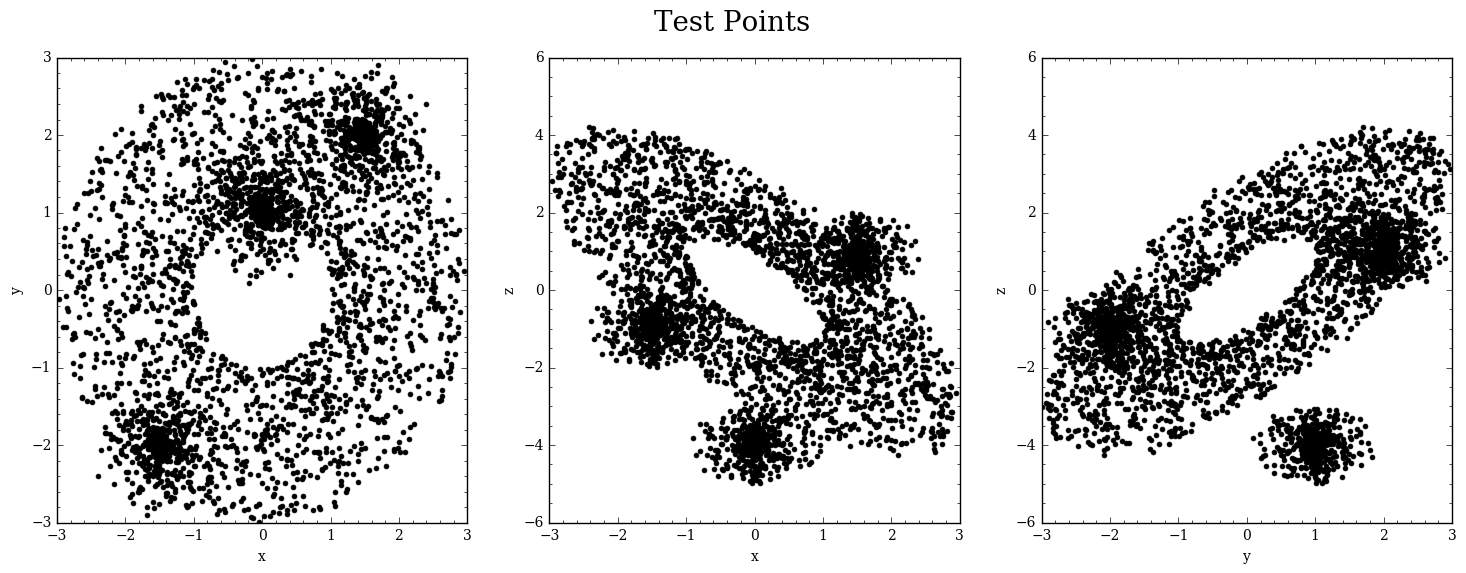

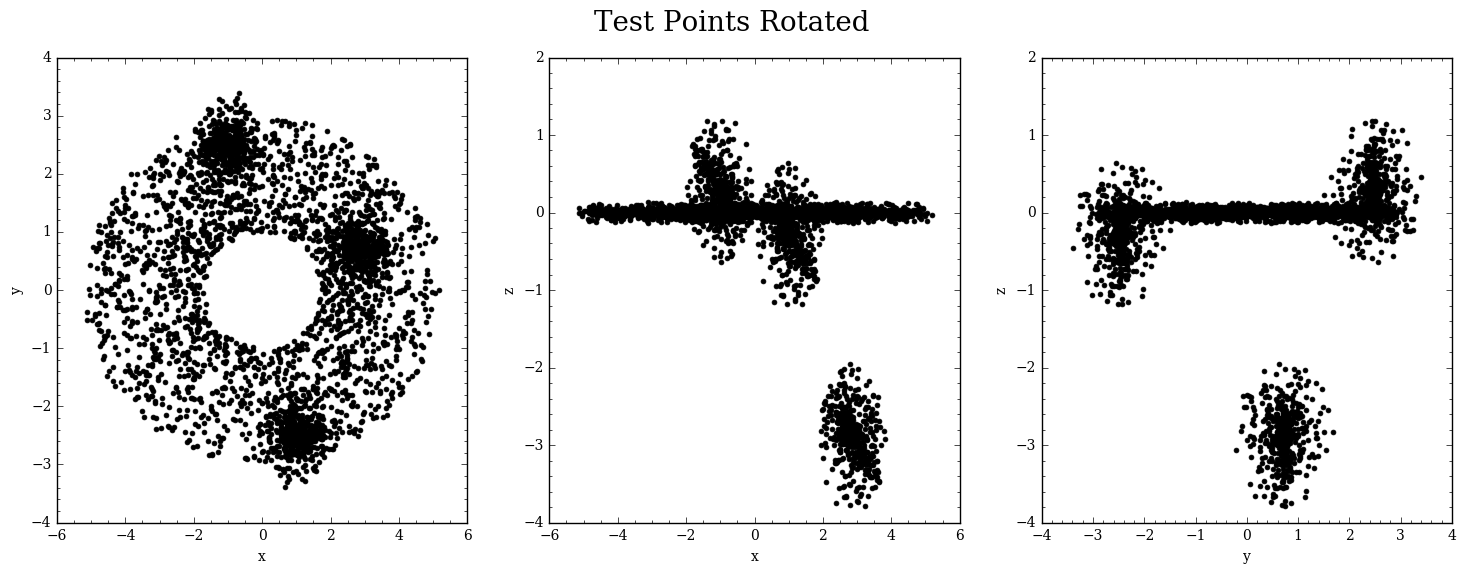

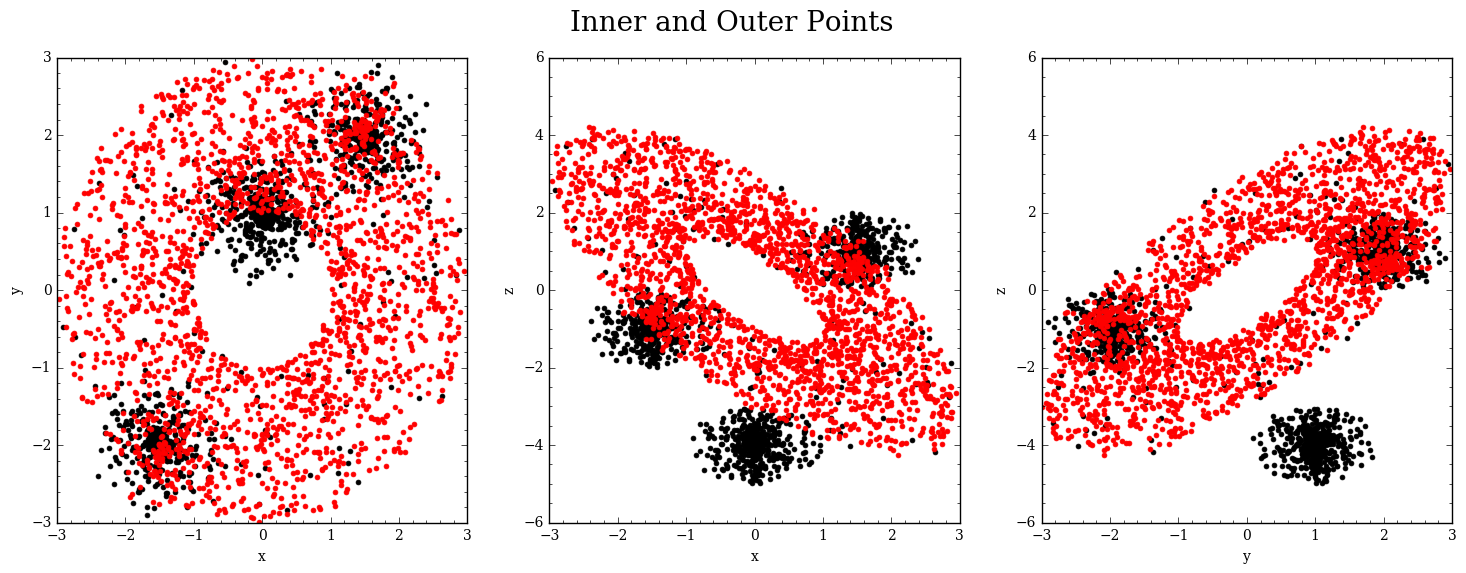

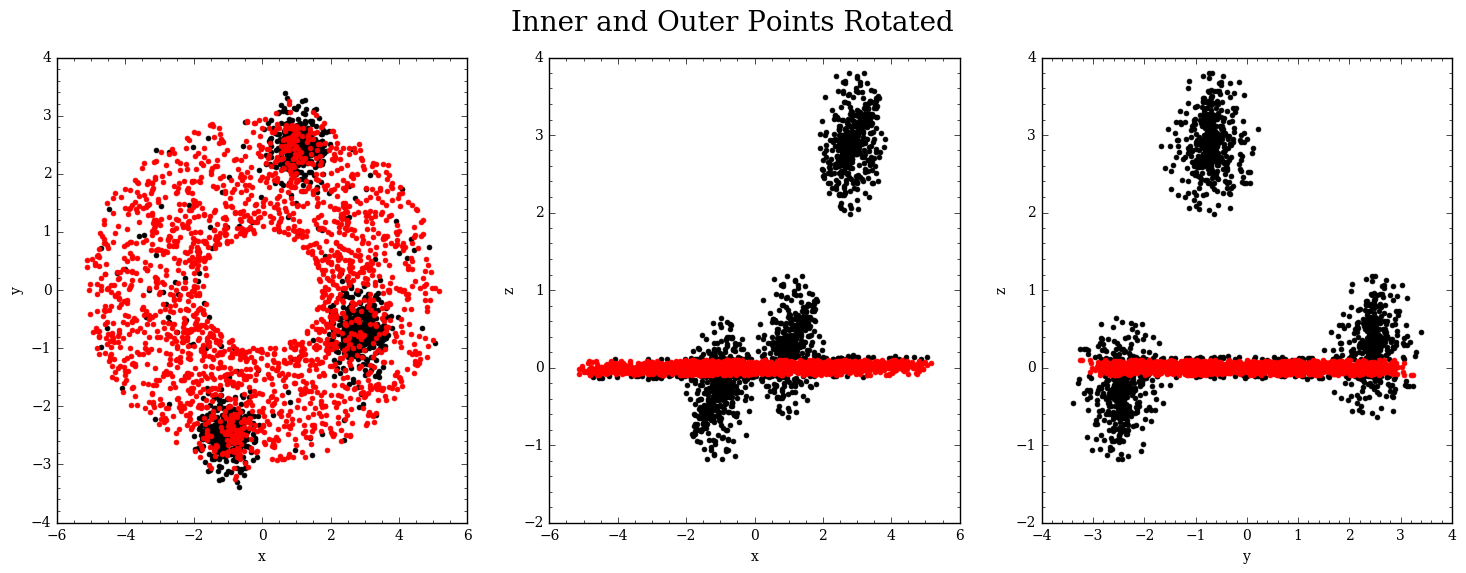

In [6]:
Np = 2000
A_true, B_true, C_true = 1, -1, 1
A_true, B_true, C_true = np.array([A_true, B_true, C_true])/np.linalg.norm([A_true, B_true, C_true])


rand_theta = 2*np.pi*np.random.random_sample(Np)
rand_R = 1+2*np.random.random_sample(Np)

x,y = rand_R*np.cos(2*np.pi*rand_theta), rand_R*np.sin(2*np.pi*rand_theta)

z = -A_true/C_true * x - B_true/C_true * y

z += (np.random.random_sample(Np)-0.5)*np.random.random_sample(Np)/2

rand_theta = np.pi*np.random.random_sample(Np/4) 
rand_phi = 2*np.pi*np.random.random_sample(Np/4)
rand_R = np.random.random_sample(Np/4)

outliners_x = rand_R*np.sin(rand_theta)*np.cos(rand_phi) + 1.5
outliners_y = rand_R*np.sin(rand_theta)*np.sin(rand_phi) + 2
outliners_z = rand_R*np.cos(rand_theta) + 1

x = np.concatenate((x,outliners_x))
y = np.concatenate((y,outliners_y))
z = np.concatenate((z,outliners_z))

outliners_x = rand_R*np.sin(rand_theta)*np.cos(rand_phi) + 1.5
outliners_y = rand_R*np.sin(rand_theta)*np.sin(rand_phi) + 2
outliners_z = rand_R*np.cos(rand_theta) + 1

x = np.concatenate((x,-outliners_x))
y = np.concatenate((y,-outliners_y))
z = np.concatenate((z,-outliners_z))

outliners_x = rand_R*np.sin(rand_theta)*np.cos(rand_phi) 
outliners_y = rand_R*np.sin(rand_theta)*np.sin(rand_phi) - 1
outliners_z = rand_R*np.cos(rand_theta) + 4

x = np.concatenate((x,-outliners_x))
y = np.concatenate((y,-outliners_y))
z = np.concatenate((z,-outliners_z))

points = np.stack([x,y,z],axis=1)

A_ls, B_ls, C_ls = plane_fit(points)
A_ls, B_ls, C_ls = [A_ls, B_ls, C_ls]/np.linalg.norm([A_ls, B_ls, C_ls])

points_in, points_out,vectN,_ = RANSAC3(points,3,100,.1)
vectN = vectN/np.linalg.norm(vectN)

fig, ax = plt.subplots(ncols=3, nrows=1,figsize=[6*3, 6])
fig.suptitle('Test Points', fontsize=20)
ax[0].plot(points[:,0],points[:,1],'k.',ms=7,alpha=2)
ax[0].set(xlabel='x', ylabel='y')
ax[0].minorticks_on()

ax[1].plot(points[:,0],points[:,2],'k.',ms=7,alpha=2)
ax[1].set(xlabel='x', ylabel='z')#,xlim=(-3,3),ylim=(-8,8))
ax[1].minorticks_on()


ax[2].set(xlabel='y', ylabel='z')
ax[2].plot(points[:,1],points[:,2],'k.',ms=7)
ax[2].minorticks_on()

################################################################################

_,_,_,_,points = rotar_plano(A_true, B_true, C_true,points)

fig, ax = plt.subplots(ncols=3, nrows=1,figsize=[6*3, 6])
fig.suptitle('Test Points Rotated', fontsize=20)
ax[0].plot(points[:,0],points[:,1],'k.',ms=7,alpha=2)
ax[0].set(xlabel='x', ylabel='y')
ax[0].minorticks_on()

ax[1].plot(points[:,0],points[:,2],'k.',ms=7,alpha=2)
ax[1].set(xlabel='x', ylabel='z')#,xlim=(-3,3),ylim=(-8,8))
ax[1].minorticks_on()


ax[2].set(xlabel='y', ylabel='z')
ax[2].plot(points[:,1],points[:,2],'k.',ms=7)
ax[2].minorticks_on()

################################################################################

fig, ax = plt.subplots(ncols=3, nrows=1,figsize=[6*3, 6])
fig.suptitle('Inner and Outer Points', fontsize=20)
# ax01= ax[0].hist2d(points[:,0],points[:,1], bins=80,norm=LogNorm())
ax[0].plot(points_out[:,0],points_out[:,1],'k.',ms=7,alpha=2)
ax[0].plot(points_in[:,0],points_in[:,1],'r.',ms=7,alpha=2)
ax[0].set(xlabel='x', ylabel='y')
ax[0].minorticks_on()

ax[1].plot(points_out[:,0],points_out[:,2],'k.',ms=7,alpha=2)
ax[1].plot(points_in[:,0],points_in[:,2],'r.',ms=7,alpha=2)
ax[1].set(xlabel='x', ylabel='z')#,xlim=(-3,3),ylim=(-8,8))
ax[1].minorticks_on()

ax[2].set(xlabel='y', ylabel='z')
ax[2].plot(points_out[:,1],points_out[:,2],'k.',ms=7,alpha=2)
ax[2].plot(points_in[:,1],points_in[:,2],'r.',ms=7,alpha=2)
ax[2].minorticks_on()

################################################################################

_,_,_,_,points_in = rotar_plano(vectN[0], vectN[1], vectN[2], points_in)
_,_,_,_,points_out = rotar_plano(vectN[0], vectN[1], vectN[2], points_out)

fig, ax = plt.subplots(ncols=3, nrows=1,figsize=[6*3, 6])
fig.suptitle('Inner and Outer Points Rotated', fontsize=20)
ax[0].plot(points_out[:,0],points_out[:,1],'k.',ms=7,alpha=2)
ax[0].plot(points_in[:,0],points_in[:,1],'r.',ms=7,alpha=2)
ax[0].set(xlabel='x', ylabel='y')
ax[0].minorticks_on()

ax[1].plot(points_out[:,0],points_out[:,2],'k.',ms=7,alpha=2)
ax[1].plot(points_in[:,0],points_in[:,2],'r.',ms=7,alpha=2)
ax[1].set(xlabel='x', ylabel='z')
ax[1].minorticks_on()


ax[2].set(xlabel='y', ylabel='z')
ax[2].plot(points_out[:,1],points_out[:,2],'k.',ms=7,alpha=2)
ax[2].plot(points_in[:,1],points_in[:,2],'r.',ms=7,alpha=2)
ax[2].minorticks_on()

print('Real params:')
print('A: {0:1.3f}'.format(A_true))
print('B: {0:1.3f}'.format(B_true))
print('C: {0:1.3f}'.format(C_true))

print('\nLeast squares fitting result:')
print('A: {0:1.3f}'.format(A_ls))
print('B: {0:1.3f}'.format(B_ls))
print('C: {0:1.3f}'.format(C_ls))

print('\nRANSAC fitting result:')
print('A: {0:1.3f}'.format(vectN[0]))
print('B: {0:1.3f}'.format(vectN[1]))
print('C: {0:1.3f}'.format(vectN[2]))